In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
X_train = pd.read_csv('X_train')
y_train = pd.read_csv('y_train')
X_test = pd.read_csv('X_test')
y_test = pd.read_csv('y_test')

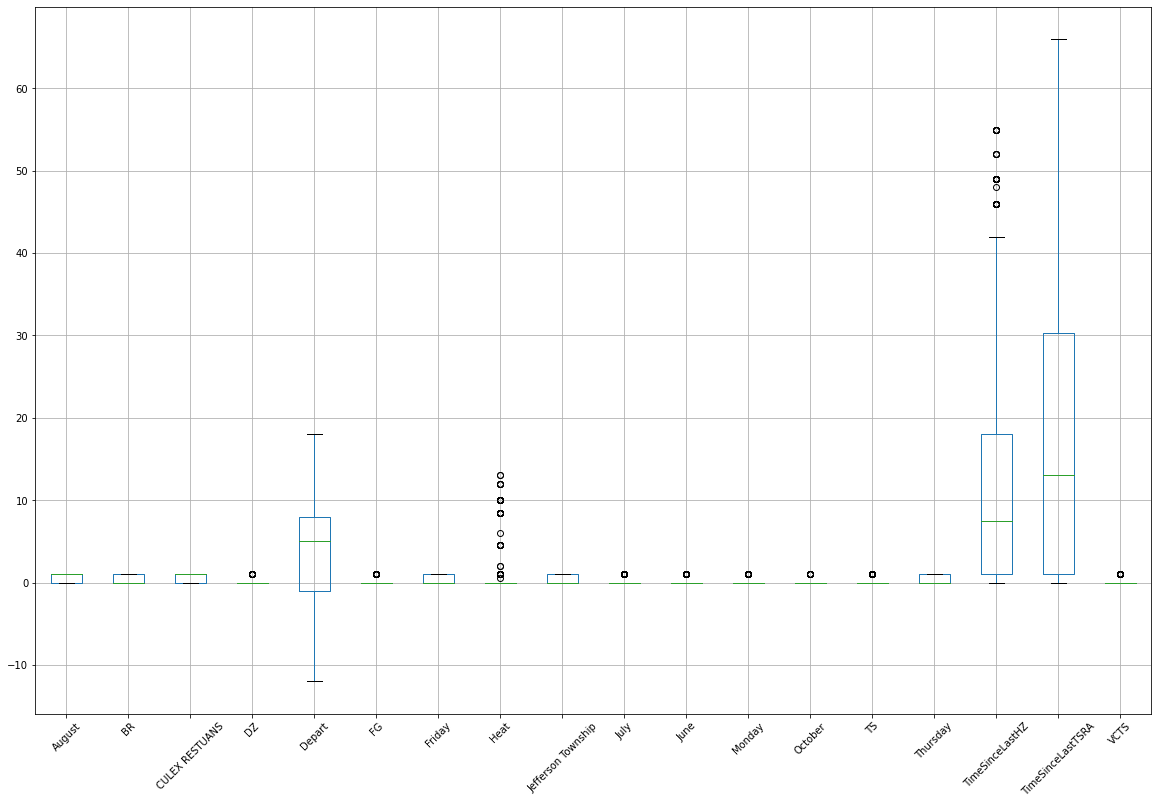

In [4]:
plt.figure(figsize=(20,13))
X_train.boxplot()
plt.xticks(rotation=45);

# Random Forest Model:

In [5]:
#First we need to scale our data before we fit our model.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_test = X_test[X_train.columns] #This is to match the testing set columns with the ones decided in our previous notebook for the training set.
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

Features [0.11235597 0.02458869 0.07298264 0.0098391  0.1229555  0.0187564
 0.01850398 0.02586418 0.10948776 0.05301776 0.08320987 0.017079
 0.0020741  0.01755535 0.02292527 0.10230083 0.16800438 0.01849922]


C:\Users\Smartjuice\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


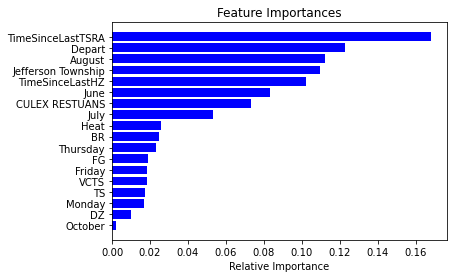

Random Forest: Accuracy=0.680
Random Forest: F1 Score=0.679
Random Forest: ROC Score=0.685


In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 50, random_state = 42, max_depth=50)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

print("Features",clf.feature_importances_)

importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc1 = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: F1 Score=%.3f' % (f1))

print('Random Forest: ROC Score=%.3f' % (roc1))

In [8]:
cm

array([[109,  69],
       [ 37, 116]], dtype=int64)

# XG Boost Model:

XG Boost: Accuracy=0.695
XG Boost: f1-score=0.695
XG Boost: ROC Score=0.699


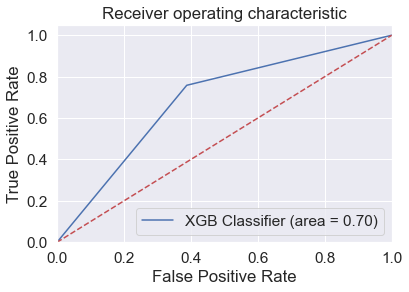

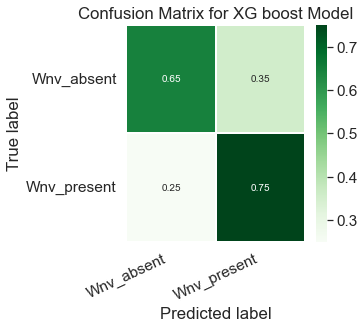

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic',use_label_encoder=False,eval_metric='auc')
xgb_model = xgb.fit(X_train,y_train)
y_pred2 = xgb_model.predict(X_test)

ac_xgb = accuracy_score(y_test, y_pred2)
f1_xgb = f1_score(y_test, y_pred2, average='weighted')
cm_xgb = confusion_matrix(y_test, y_pred2)
roc_xgb = roc_auc_score(y_test, y_pred2)

print('XG Boost: Accuracy=%.3f' % (ac_xgb))
print('XG Boost: f1-score=%.3f' % (f1_xgb))
print('XG Boost: ROC Score=%.3f' % (roc_xgb))


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc_xgb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

cm_xgb = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(cm_xgb, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


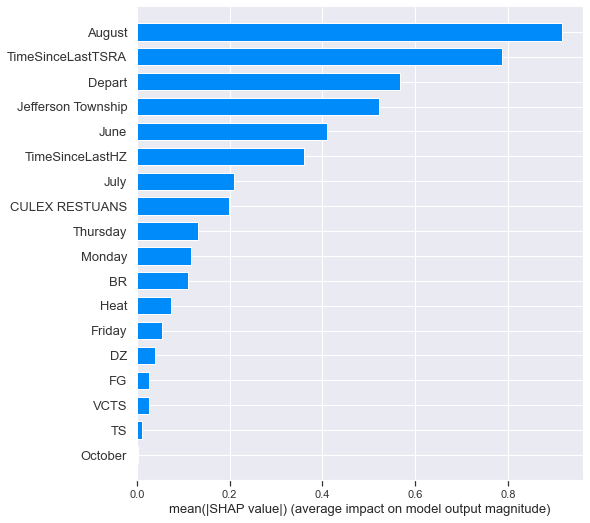

In [10]:
import shap
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

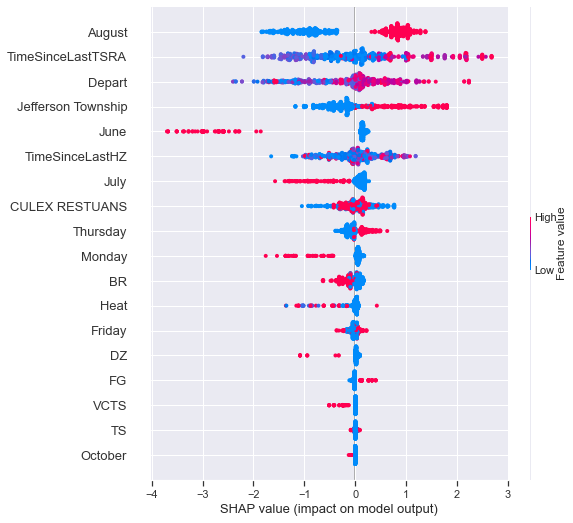

In [11]:
shap.summary_plot(shap_values, X_train)

# Hyperparameter Optimization

In [12]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    'learning_rate': np.arange(.01,0.5),
    'n_estimators': np.arange(100,1500),
    'max_depth': np.arange(3,12),
    'subsample': np.arange(0.6,1)
}
rs = RandomizedSearchCV(xgb,param_distributions=param_distributions,n_iter=25,cv=5,random_state=42,scoring='roc_auc',verbose=0)
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constrai...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subs

In [13]:
print("Best Score:" + str(rs.best_score_))
print("Best Parameters: " + str(rs.best_params_))

Best Score:0.8346278101038663
Best Parameters: {'subsample': 0.6, 'n_estimators': 263, 'max_depth': 11, 'learning_rate': 0.01}


In [14]:
rs.best_score_

0.8346278101038663

# Creating a New XG Boost Model Using the Optimized Hyperparameters

[22:47:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:47:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XG Boost: Accuracy=0.689
XG Boost: f1-score=0.688
XG Boost: ROC Score=0.694


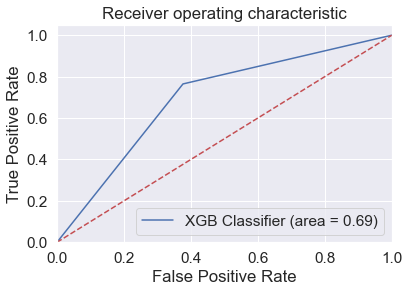

[[111  67]
 [ 36 117]]


In [15]:
xgb_optimal = XGBClassifier(scoring_fit='roc_auc',subsample=0.6,n_estimators=326,max_depth=6,learning_rate=0.01,random_state = 42)
xgb_final = xgb_optimal.fit(X_train,y_train)
y_pred_final = xgb_final.predict(X_test)

ac_xgb_final = accuracy_score(y_test, y_pred_final)
f1_xgb_final = f1_score(y_test, y_pred_final, average='weighted')
cm_xgb_final = confusion_matrix(y_test, y_pred_final)
roc_xgb_final = roc_auc_score(y_test, y_pred_final)

print('XG Boost: Accuracy=%.3f' % (ac_xgb_final))
print('XG Boost: f1-score=%.3f' % (f1_xgb_final))
print('XG Boost: ROC Score=%.3f' % (roc_xgb_final))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_final)
plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc_xgb_final)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

print(cm_xgb_final)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


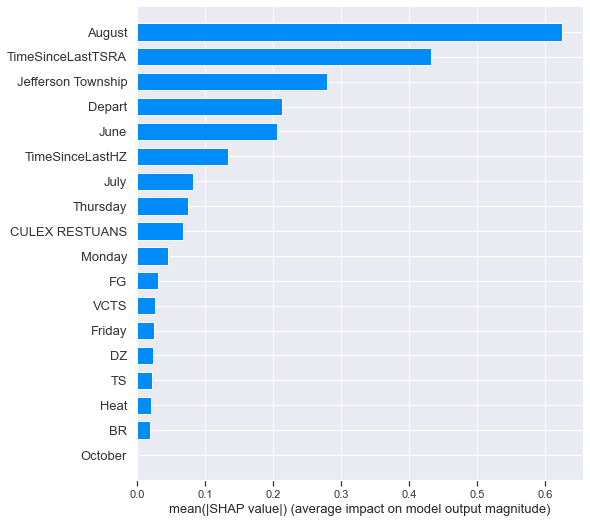

In [16]:
shap_values = shap.TreeExplainer(xgb_final).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Seems like the randomized search did not find any better hyperparameter combination than the default one. In that case, we can conclude by saying our previous XG Boost model is our best model.